In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt


In [96]:
def get_df():
  path = 'drive/My Drive/ADL project/test_prediction.csv'
  df = pd.read_csv(path)
  cols = [col for col in df.columns if col.startswith('predictions')]
  return df, cols
df, cols = get_df()
df['labels'].replace(2, 0,inplace=True)
df.replace(0.5, 0.15, inplace=True)
df.head()


,slide_name,x,y,labels,suffix,predictions,predictions_N,predictions_S,predictions_E,predictions_W,predictions_NE,predictions_SE,predictions_NW,predictions_SW
0,tumor_012,4200,1500,0,0,0.997868,0.15,0.15,0.150000,0.150000,0.15,0.15,0.15,0.15
1,tumor_012,6000,1500,0,1,0.938008,0.15,0.15,0.988201,0.150000,0.15,0.15,0.15,0.15
2,tumor_012,6300,1500,0,2,0.988201,0.15,0.15,0.843788,0.938008,0.15,0.15,0.15,0.15
3,tumor_012,6600,1500,0,3,0.843788,0.15,0.15,0.430356,0.988201,0.15,0.15,0.15,0.15
4,tumor_012,6900,1500,0,4,0.430356,0.15,0.15,0.998907,0.843788,0.15,0.15,0.15,0.15


In [4]:
# update to latest version for feature importance plot, not necessary for modeling
!pip uninstall scikit-learn -y
!pip install Cython
!pip install git+git://github.com/scikit-learn/scikit-learn.git


Uninstalling scikit-learn-0.21.3:
  Successfully uninstalled scikit-learn-0.21.3
  Cloning git://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-_j3wq4hp
  Running command git clone -q git://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-_j3wq4hp
  Created wheel for scikit-learn: filename=scikit_learn-0.23.dev0-cp36-cp36m-linux_x86_64.whl size=17114769 sha256=57d01403d9517c756b09d6589e686dd1f2ecacf3a276fba2b224c6e95211c6b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-magrqrdv/wheels/a1/50/0e/316ef2ff8d4cfade292bd20b49efda94727688a153382745a6
Successfully built scikit-learn


In [5]:
import sklearn
sklearn.__version__


'0.23.dev0'

In [0]:
test_images = ['tumor_031', 'tumor_091', 'tumor_110']
train_images = [col for col in df.slide_name.unique() if col not in test_images]

df_train = df[df['slide_name'].isin(train_images)]
df_test = df[df['slide_name'].isin(test_images)]


In [0]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import permutation_importance


In [98]:
# baseline
clf = LogisticRegressionCV(cv=5, 
                           random_state=42,
                           class_weight='balanced').fit(df_train[cols],df_train.labels)
clf.score(df_test[cols],df_test.labels)


0.8748925193465176

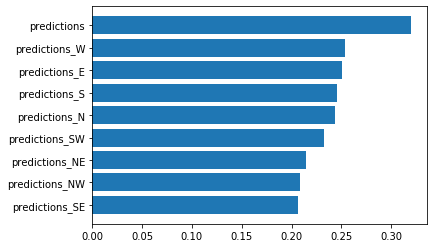

In [99]:
def plot_weights(clf, X):
  sorted_idx = clf.coef_[0].argsort()
  _ = plt.barh(y=range(9),
           width=clf.coef_[0][sorted_idx],
           tick_label=X.columns[sorted_idx])
plot_weights(clf,df_train[cols])

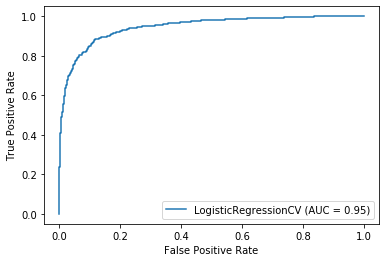

In [100]:
clf_disp = plot_roc_curve(clf, df_test[cols], df_test.labels)

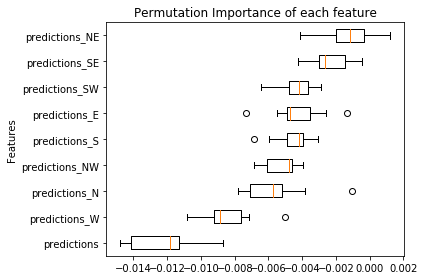

In [101]:
def plot_feature_importance(clf, X, y):
  result = permutation_importance(clf, X, y, n_repeats=10, random_state=0, n_jobs=-1)
  fig, ax = plt.subplots()
  sorted_idx = result.importances_mean.argsort()
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
  ax.set_title("Permutation Importance of each feature")
  ax.set_ylabel("Features")
  fig.tight_layout()
  plt.show()
plot_feature_importance(clf, df_train[cols], df_train.labels)

In [0]:
def upsampling(df):
  df_minority = df[df.labels==1]
  df_majority = df[df.labels==0]
  # upsampling
  df_minority_upsampled = resample(df_minority,
                                   replace=True,
                                   n_samples=df_majority.shape[0],
                                   random_state=42)
  df_upsampled = pd.concat([df_majority, df_minority_upsampled])
  # check
  print(df_upsampled.labels.value_counts())
  return df_upsampled
  

In [103]:
df_upsampled = upsampling(df_train)
X = df_upsampled[cols]
y = df_upsampled['labels']


1    6184
0    6184
Name: labels, dtype: int64


In [104]:
clf = LogisticRegressionCV(cv=5, random_state=42).fit(X, y)
clf.score(df_test[cols], df_test.labels)


0.8774720550300946

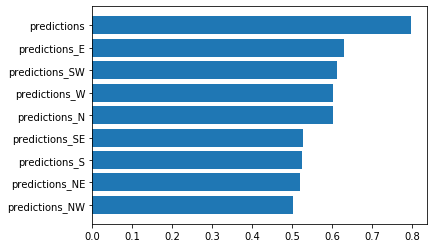

In [105]:
plot_weights(clf,X)

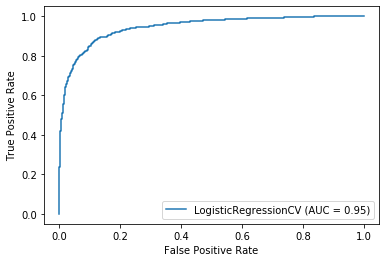

In [106]:
clf_disp = plot_roc_curve(clf,df_test[cols], df_test.labels)

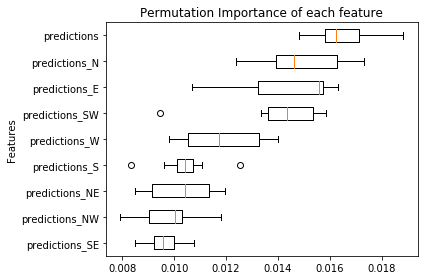

In [107]:
plot_feature_importance(clf,X,y)

In [114]:
# rf baseline
rf = RandomForestClassifier(max_depth=2,
                            random_state=42,
                            class_weight='balanced').fit(df_train[cols],df_train.labels)
rf.score(df_test[cols], df_test.labels)


0.8705932932072227

In [123]:
df_test['lr_preds'] = clf.predict_proba(df_test[cols])[:, 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_test.to_csv('drive/My Drive/ADL project/lr_results.csv', index=None)


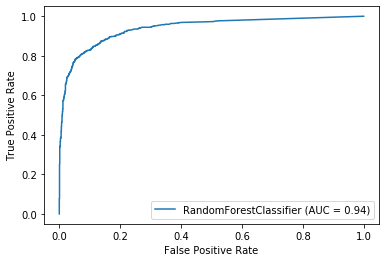

In [125]:
rf_disp = plot_roc_curve(rf,df_test[cols], df_test.labels)

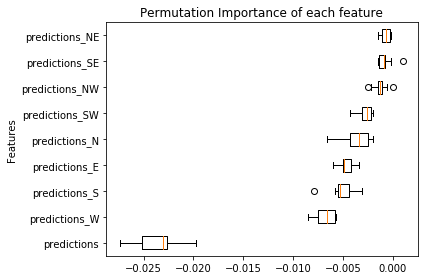

In [126]:
plot_feature_importance(rf,df_train[cols],df_train.labels)

In [127]:
# upsampling
rf = RandomForestClassifier(max_depth=2,
                            random_state=42).fit(X,y)
rf.score(df_test[cols], df_test.labels)


0.8680137575236457